In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('CFB_Gambling_Predictors_Final_PBP.csv')
data.head()

away_team    game_id       home_team  season  week  neutral_site  \
0  Air Force  400764876            Navy    2015     5         False   
1  Air Force  400790881     Boise State    2015    12         False   
2  Air Force  400868918            Army    2016    10         False   
3  Air Force  400869231    Fresno State    2016     9         False   
4  Air Force  400869247  San José State    2016    12         False   

   conference_game  spread  home_favored  home_covered  ...  \
0            False     6.0             1             1  ...   
1             True    14.5             1             0  ...   
2            False     3.0             0             0  ...   
3             True    13.5             0             1  ...   
4             True    11.0             0             1  ...   

   away_total_receiving_ppa  away_total_rushing_ppa  away_percent_ppa  \
0                     102.8                    87.8             0.615   
1                     102.8                    87.8             0.615   
2                      42.6                   141.6             0.563   
3                      42.6                   141.6             0.563   
4                      42.6                   141.6             0.563   

   away_percent_passing_ppa  away_percent_receiving_ppa  \
0                     0.134                       0.862   
1                     0.134                       0.862   
2                     0.347                       0.356   
3                     0.347                       0.356   
4                     0.347                       0.356   

   away_percent_rushing_ppa  away_usage  away_passing_usage  \
0                     0.686       0.646               0.162   
1                     0.686       0.646               0.162   
2                     0.801       0.625               0.145   
3                     0.801       0.625               0.145   
4                     0.801       0.625               0.145   

   away_receiving_usage  away_rushing_usage  
0                  0.95               0.711  
1                  0.95               0.711  
2                  0.56               0.741  
3                  0.56               0.741  
4                  0.56               0.741  

[5 rows x 1054 columns]

In [3]:
print(data.columns)

Index(['away_team', 'game_id', 'home_team', 'season', 'week', 'neutral_site',
       'conference_game', 'spread', 'home_favored', 'home_covered',
       ...
       'away_total_receiving_ppa', 'away_total_rushing_ppa',
       'away_percent_ppa', 'away_percent_passing_ppa',
       'away_percent_receiving_ppa', 'away_percent_rushing_ppa', 'away_usage',
       'away_passing_usage', 'away_receiving_usage', 'away_rushing_usage'],
      dtype='object', length=1054)


In [4]:
exclude_vars = ["game_id", "home_team", "away_team"]
predictors = [col for col in data.columns if col not in exclude_vars + ["home_covered"]]

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [6]:
X = data[predictors]
y = data["home_covered"]

# Train-test split based on season
X_train = X[data["season"].between(2015, 2022)]
y_train = y[data["season"].between(2015, 2022)]
X_test  = X[data["season"].between(2023, 2024)]
y_test  = y[data["season"].between(2023, 2024)]

In [7]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_seed=42
    )
}

In [8]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    # Train predictions
    preds_train = model.predict(X_train)
    probs_train = model.predict_proba(X_train)[:, 1]

    # Test predictions
    preds_test = model.predict(X_test)
    probs_test = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Train_Accuracy": accuracy_score(y_train, preds_train),
        "Test_Accuracy": accuracy_score(y_test, preds_test),
        "Train_F1": f1_score(y_train, preds_train),
        "Test_F1": f1_score(y_test, preds_test),
        "Train_ROC_AUC": roc_auc_score(y_train, probs_train),
        "Test_ROC_AUC": roc_auc_score(y_test, probs_test)
    })

    print(f"\n{name} — TRAIN")
    print(classification_report(y_train, preds_train, digits=3))
    print(f"{name} — TEST")
    print(classification_report(y_test, preds_test, digits=3))

results_df = pd.DataFrame(results)
print("\nSummary of Train vs Test Performance:")
print(results_df.sort_values("Test_ROC_AUC", ascending=False))


RandomForest — TRAIN
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       867
           1      1.000     1.000     1.000       812

    accuracy                          1.000      1679
   macro avg      1.000     1.000     1.000      1679
weighted avg      1.000     1.000     1.000      1679

RandomForest — TEST
              precision    recall  f1-score   support

           0      0.523     0.479     0.500       257
           1      0.479     0.523     0.500       235

    accuracy                          0.500       492
   macro avg      0.501     0.501     0.500       492
weighted avg      0.502     0.500     0.500       492


GradientBoosting — TRAIN
              precision    recall  f1-score   support

           0      0.964     0.958     0.961       867
           1      0.956     0.962     0.959       812

    accuracy                          0.960      1679
   macro avg      0.960     0.960     0.960      1679
weight

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:56:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost — TRAIN
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       867
           1      1.000     1.000     1.000       812

    accuracy                          1.000      1679
   macro avg      1.000     1.000     1.000      1679
weighted avg      1.000     1.000     1.000      1679

XGBoost — TEST
              precision    recall  f1-score   support

           0      0.548     0.447     0.493       257
           1      0.496     0.596     0.542       235

    accuracy                          0.518       492
   macro avg      0.522     0.522     0.517       492
weighted avg      0.523     0.518     0.516       492

[LightGBM] [Info] Number of positive: 812, number of negative: 867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152347
[LightGBM] [Info] Number of data points in the tr

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define parameter grid
param_dist = {
    "n_estimators": [200, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5, 7],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "gamma": [0, 0.5, 1, 2],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [0.5, 1, 2]
}

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=50,                 # number of random configs to try
    scoring="roc_auc",         # optimize ROC AUC
    cv=3,                      # 3-fold CV within training years
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:02] WARN

[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=  10.4s
[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.5, subsample=0.6; total time=  24.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.5, subsample=0.6; total time=  24.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.6; total time=  50.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.6; total time=  51.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.6; total time=  51.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=  56.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=  57.2s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=  57.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.5, subsample=0.6; total time=  23.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=   8.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=   9.1s
[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=   9.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=  29.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7; total time=  18.8s
[CV] END colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7; total time=  19.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=  29.1s
[CV] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=  29.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   7.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  10.9s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   8.1s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   7.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=  15.4s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=  14.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time=  17.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time=  17.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=  33.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=  32.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=  33.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time=  19.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=1.0; total time=  17.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=1.0; total time=  18.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=1.0; total time=  17.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=   7.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=   7.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=  17.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=   7.1s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=  17.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time=  26.7s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time=  25.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time=  25.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=  25.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=  25.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=  25.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=  14.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=  14.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time=  51.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time=  51.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=  33.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=  32.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=  32.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time=  50.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=0.6; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=0.6; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=  21.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=  21.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=  21.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=0.6; total time=  10.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=  30.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.6; total time=   8.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=  29.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:32] WARN

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=  30.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.6; total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.6; total time=   8.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=  15.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=0.7; total time=   8.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=0.7; total time=   8.7s
[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=  15.5s
[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=  15.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=  21.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=  20.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=  21.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=0.7; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:00:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.6; total time=  16.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.6; total time=  15.6s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.6; total time=  15.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=  25.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=  25.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.6; total time=  37.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=2, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=  26.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.6; total time=  38.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.6; total time=  38.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   6.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=  20.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=  22.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=  21.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=  41.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=  42.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=  43.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, subsample=0.7; total time=  31.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=  42.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, subsample=0.7; total time=  32.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=  41.7s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, subsample=0.7; total time=  32.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=  41.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  14.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, subsample=0.7; total time=  44.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, subsample=0.7; total time=  44.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, subsample=0.7; total time=  46.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=  13.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=  13.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=  13.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=  31.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=  31.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  13.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  13.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=  31.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=  10.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=  28.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=  28.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=  27.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500, reg_alpha=1, reg_lambda=0.5, subsample=0.6; total time=  22.9s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500, reg_alpha=1, reg_lambda=0.5, subsample=0.6; total time=  23.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, reg_alpha=1, reg_lambda=0.5, subsample=0.8; total time=  38.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500, reg_alpha=1, reg_lambda=0.5, subsample=0.6; total time=  22.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, reg_alpha=1, reg_lambda=0.5, subsample=0.8; total time=  38.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=2, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=  23.4s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, reg_alpha=1, reg_lambda=0.5, subsample=0.8; total time=  37.1s
[CV] END colsample_bytree=0.8, gamma=2, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=  23.1s
[CV] END colsample_bytree=0.8, gamma=2, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=1000, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=  18.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=  21.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, re

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.7}
Best CV Score: 0.5364800083986999


In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

best_params = {
    'subsample': 1.0,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'max_depth': 4,
    'learning_rate': 0.1,
    'gamma': 2,
    'colsample_bytree': 0.7,
    'random_state': 42,
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'n_jobs': -1
}

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# ---------------------------
# 2. Evaluate on train/test
# ---------------------------
probs_train = best_model.predict_proba(X_train)[:, 1]
probs_test  = best_model.predict_proba(X_test)[:, 1]

# baseline ROC-AUC
print("Train ROC-AUC:", roc_auc_score(y_train, probs_train))
print("Test ROC-AUC:", roc_auc_score(y_test, probs_test))

# ---------------------------
# 3. Evaluate different probability thresholds
# ---------------------------
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7]
results = []

for th in thresholds:
    preds_test = (probs_test >= th).astype(int)
    results.append({
        "Threshold": th,
        "Accuracy": accuracy_score(y_test, preds_test),
        "Precision": precision_score(y_test, preds_test, zero_division=0),
        "Recall": recall_score(y_test, preds_test),
        "F1": f1_score(y_test, preds_test),
        "ROC_AUC": roc_auc_score(y_test, probs_test)  # unaffected by cutoff
    })
    
    print(f"\n=== Threshold {th} ===")
    print(classification_report(y_test, preds_test, digits=3))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 0.9997031266867802
Test ROC-AUC: 0.49494163424124515

=== Threshold 0.5 ===
              precision    recall  f1-score   support

           0      0.487     0.366     0.418       257
           1      0.455     0.579     0.509       235

    accuracy                          0.467       492
   macro avg      0.471     0.472     0.464       492
weighted avg      0.472     0.467     0.462       492


=== Threshold 0.55 ===
              precision    recall  f1-score   support

           0      0.508     0.514     0.511       257
           1      0.461     0.455     0.458       235

    accuracy                          0.486       492
   macro avg      0.484     0.484     0.484       492
weighted avg      0.485     0.486     0.486       492


=== Threshold 0.6 ===
              precision    recall  f1-score   support

           0      0.519     0.689     0.592       257
           1      0.470     0.302     0.368       235

    accuracy                          0.504 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


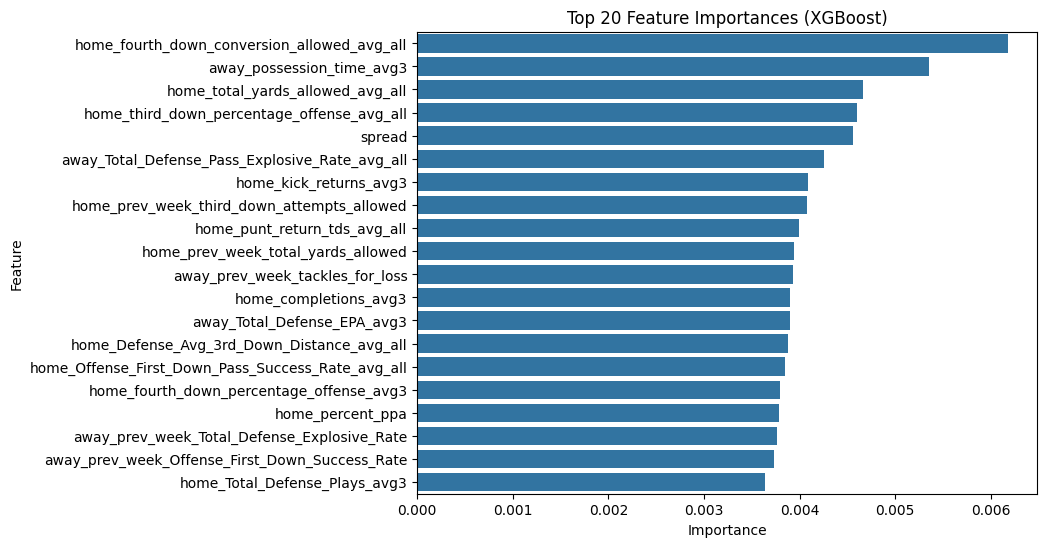

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fit XGBoost again with best params
best_model.fit(X_train, y_train)

# Get feature importance
importance = best_model.feature_importances_
feat_imp = pd.DataFrame({"Feature": X_train.columns, "Importance": importance})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

# Show top 20
plt.figure(figsize=(8,6))
sns.barplot(y="Feature", x="Importance", data=feat_imp.head(20))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

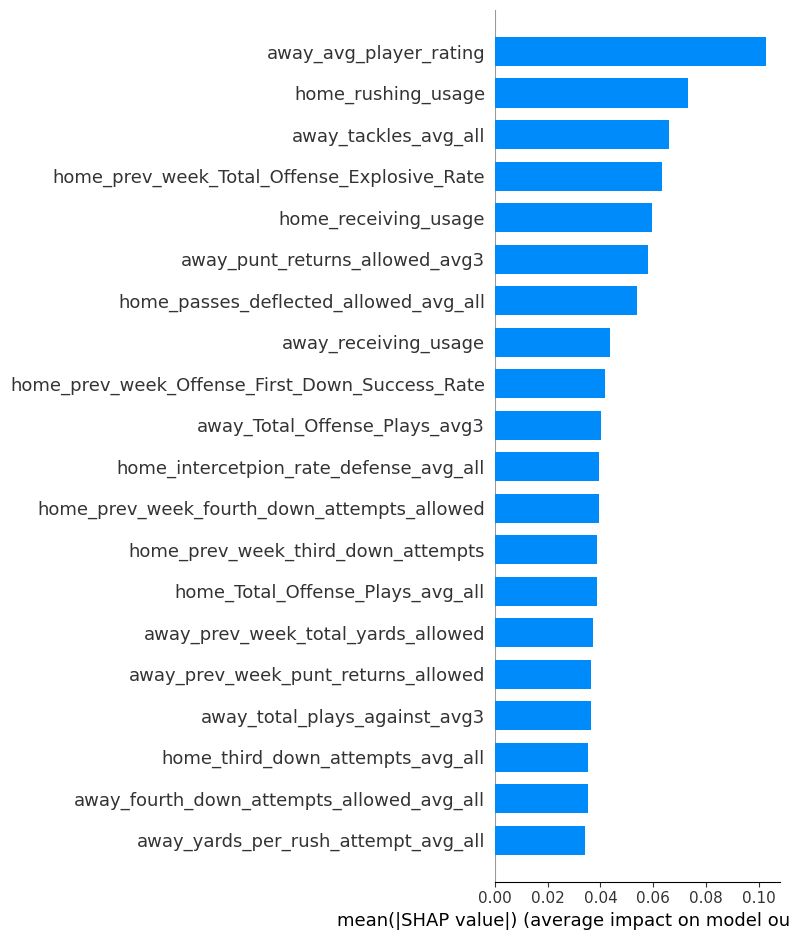

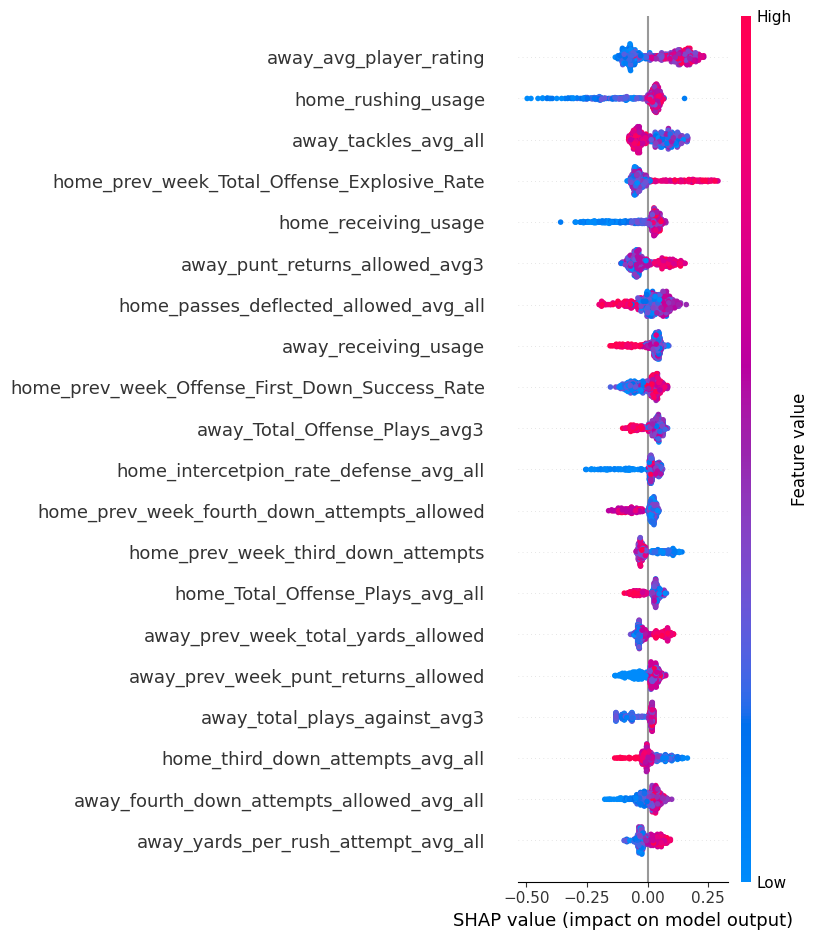

In [12]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")   # global feature importance
shap.summary_plot(shap_values, X_test)                   # detailed beeswarm plot

In [13]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# Remove near-constant features
vt = VarianceThreshold(threshold=0.01)
X_reduced = vt.fit_transform(X_train)

# Select top 100 features based on ANOVA F-score
selector = SelectKBest(score_func=f_classif, k=100)
X_new = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]
print(selected_features)

Index(['conference_game', 'home_prev_week_net_passing_yards',
       'home_prev_week_passing_tds', 'home_prev_week_yards_per_pass',
       'home_prev_week_third_down_conversion',
       'home_prev_week_third_down_attempts', 'home_prev_week_qb_hurries',
       'home_prev_week_pressure_percentage', 'home_prev_week_yards_per_play',
       'home_prev_week_total_plays_against',
       'home_prev_week_Offense_Success_Rate',
       'home_prev_week_Offense_Pass_Success_Rate',
       'home_prev_week_Total_Offense_Explosives',
       'home_prev_week_Total_Offense_Explosive_Rate',
       'home_prev_week_Total_Offense_Pass_Explosives',
       'home_prev_week_Total_Offense_Pass_Explosive_Rate',
       'home_prev_week_Offense_First_Down_Success',
       'home_prev_week_Offense_First_Down_Success_Rate',
       'home_prev_week_Offense_First_Down_Pass_Success',
       'home_prev_week_Offense_First_Down_Pass_Success_Rate',
       'home_prev_week_Total_Offense_Scoring_Drives',
       'home_prev_week_Offe

In [14]:
selector = SelectKBest(score_func=f_classif, k=100)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected  = selector.transform(X_test)

selected_features = X_train.columns[selector.get_support()]
print("Top 20 selected features:")
print(selected_features[:20])

Top 20 selected features:
Index(['conference_game', 'home_prev_week_net_passing_yards',
       'home_prev_week_passing_tds', 'home_prev_week_yards_per_pass',
       'home_prev_week_third_down_conversion',
       'home_prev_week_third_down_attempts', 'home_prev_week_qb_hurries',
       'home_prev_week_pressure_percentage', 'home_prev_week_yards_per_play',
       'home_prev_week_total_plays_against',
       'home_prev_week_Offense_Success_Rate',
       'home_prev_week_Offense_Pass_Success_Rate',
       'home_prev_week_Total_Offense_Explosives',
       'home_prev_week_Total_Offense_Explosive_Rate',
       'home_prev_week_Total_Offense_Pass_Explosives',
       'home_prev_week_Total_Offense_Pass_Explosive_Rate',
       'home_prev_week_Offense_First_Down_Success',
       'home_prev_week_Offense_First_Down_Success_Rate',
       'home_prev_week_Offense_First_Down_Pass_Success',
       'home_prev_week_Offense_First_Down_Pass_Success_Rate'],
      dtype='object')


In [15]:

# ---------------------------
# 2. Refit XGBoost with best params
# ---------------------------
best_params = {
    'subsample': 1.0,
    'reg_lambda': 2,
    'reg_alpha': 1,
    'n_estimators': 1000,
    'min_child_weight': 7,
    'max_depth': 6,
    'learning_rate': 0.05,
    'gamma': 1,
    'colsample_bytree': 0.6,
    'random_state': 42,
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'n_jobs': -1
}

best_model = XGBClassifier(**best_params)
best_model.fit(X_train_selected, y_train)

# ---------------------------
# 3. Evaluate on Train + Test
# ---------------------------
probs_train = best_model.predict_proba(X_train_selected)[:, 1]
probs_test  = best_model.predict_proba(X_test_selected)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, probs_train))
print("Test ROC-AUC:", roc_auc_score(y_test, probs_test))

print("\n=== Train Classification Report ===")
print(classification_report(y_train, (probs_train >= 0.5).astype(int), digits=3))

print("\n=== Test Classification Report ===")
print(classification_report(y_test, (probs_test >= 0.5).astype(int), digits=3))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 0.9995795478434781
Test ROC-AUC: 0.48878218395562545

=== Train Classification Report ===
              precision    recall  f1-score   support

           0      0.992     0.993     0.993       867
           1      0.993     0.991     0.992       812

    accuracy                          0.992      1679
   macro avg      0.992     0.992     0.992      1679
weighted avg      0.992     0.992     0.992      1679


=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.516     0.514     0.515       257
           1      0.470     0.472     0.471       235

    accuracy                          0.494       492
   macro avg      0.493     0.493     0.493       492
weighted avg      0.494     0.494     0.494       492



In [16]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, .75, .8, .85, .9, .95]
results = []

for th in thresholds:
    preds_test = (probs_test >= th).astype(int)
    results.append({
        "Threshold": th,
        "Accuracy": accuracy_score(y_test, preds_test),
        "Precision": precision_score(y_test, preds_test, zero_division=0),
        "Recall": recall_score(y_test, preds_test),
        "F1": f1_score(y_test, preds_test),
        "ROC_AUC": roc_auc_score(y_test, probs_test)  # unchanged by threshold
    })

results_df = pd.DataFrame(results)
print("\nSummary across thresholds:")
print(results_df)


Summary across thresholds:
   Threshold  Accuracy  Precision    Recall        F1   ROC_AUC
0       0.50  0.493902   0.470339  0.472340  0.471338  0.488782
1       0.55  0.504065   0.476684  0.391489  0.429907  0.488782
2       0.60  0.518293   0.492188  0.268085  0.347107  0.488782
3       0.65  0.520325   0.493827  0.170213  0.253165  0.488782
4       0.70  0.518293   0.480000  0.102128  0.168421  0.488782
5       0.75  0.518293   0.458333  0.046809  0.084942  0.488782
6       0.80  0.522358   0.500000  0.008511  0.016736  0.488782
7       0.85  0.522358   0.500000  0.004255  0.008439  0.488782
8       0.90  0.522358   0.000000  0.000000  0.000000  0.488782
9       0.95  0.522358   0.000000  0.000000  0.000000  0.488782


In [17]:
from sklearn.inspection import permutation_importance

# Use the already-fitted selector
X_test_selected = selector.transform(X_test)

# Run permutation importance on the reduced feature set
perm = permutation_importance(
    best_model,
    X_test_selected,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

# Map back to the names of the selected features
perm_df = pd.DataFrame({
    "Feature": selected_features,
    "Importance": perm.importances_mean
})

print(perm_df.sort_values("Importance", ascending=False).head(20))

                                             Feature  Importance
68         away_fourth_down_attempts_allowed_avg_all    0.011484
17    home_prev_week_Offense_First_Down_Success_Rate    0.007724
70                    away_punt_returns_allowed_avg3    0.006606
29                  home_Total_Offense_Plays_avg_all    0.006098
88     away_Offense_Scoring_Drive_Percentage_avg_all    0.005996
4               home_prev_week_third_down_conversion    0.004980
77                     away_total_plays_against_avg3    0.003760
53               away_prev_week_punt_returns_allowed    0.003760
35         home_Offense_First_Down_Success_Rate_avg3    0.003659
55                away_prev_week_Total_Defense_Plays    0.002947
92            away_Defense_first_down_pass_rate_avg3    0.002846
62                         away_possession_time_avg3    0.002744
94          away_Defense_First_Down_Run_Success_avg3    0.002642
73                 away_possession_time_allowed_avg3    0.002541
27                       

In [18]:
from sklearn.inspection import permutation_importance
import pandas as pd

# ---------------------------
# 1. Refit XGBoost on ALL features
# ---------------------------
best_params = {
    'subsample': 1.0,
    'reg_lambda': 2,
    'reg_alpha': 1,
    'n_estimators': 1000,
    'min_child_weight': 7,
    'max_depth': 6,
    'learning_rate': 0.05,
    'gamma': 1,
    'colsample_bytree': 0.6,
    'random_state': 42,
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'n_jobs': -1
}

best_model_full = XGBClassifier(**best_params)
best_model_full.fit(X_train, y_train)

# ---------------------------
# 2. Permutation Importance (on full test set)
# ---------------------------
perm = permutation_importance(
    best_model_full,
    X_test,
    y_test,
    n_repeats=50,          # more repeats = more stable results
    random_state=42,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm.importances_mean
}).sort_values("Importance", ascending=False)

# ---------------------------
# 3. View results
# ---------------------------
print("\nTop 20 Predictors (Permutation Importance):")
print(perm_df.head(20))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Top 20 Predictors (Permutation Importance):
                                              Feature  Importance
130    home_prev_week_Offense_First_Down_Success_Rate    0.017764
775                         away_possession_time_avg3    0.010772
714                     away_interception_tds_avg_all    0.009959
322             home_passes_deflected_allowed_avg_all    0.009146
587               away_prev_week_punt_returns_allowed    0.008780
793              away_interception_yards_allowed_avg3    0.008659
812         away_fourth_down_attempts_allowed_avg_all    0.008455
887                     away_total_plays_against_avg3    0.008171
501    home_Defense_First_Down_Pass_Success_Rate_avg3    0.007764
948  away_Offense_First_Down_Run_Success_Rate_avg_all    0.007317
569                away_prev_week_total_yards_allowed    0.007154
879                     away_penalty_yard_margin_avg3    0.007114
797                away_rushing_attempts_allowed_avg3    0.006951
421              home_Offense_F

In [44]:
perm_df[perm_df['Importance'] > .002]['Feature']

130     home_prev_week_Offense_First_Down_Success_Rate
775                          away_possession_time_avg3
714                      away_interception_tds_avg_all
322              home_passes_deflected_allowed_avg_all
587                away_prev_week_punt_returns_allowed
                             ...                      
93            home_prev_week_intercetpion_rate_defense
976         away_Defense_Avg_3rd_Down_Distance_avg_all
1029        away_Defense_Scoring_Drive_Percentage_avg3
871                away_intercetpion_rate_defense_avg3
367                  home_rush_percentage_against_avg3
Name: Feature, Length: 122, dtype: object

In [20]:
perm_df

Feature  Importance
130   home_prev_week_Offense_First_Down_Success_Rate    0.017764
775                        away_possession_time_avg3    0.010772
714                    away_interception_tds_avg_all    0.009959
322            home_passes_deflected_allowed_avg_all    0.009146
587              away_prev_week_punt_returns_allowed    0.008780
...                                              ...         ...
124      home_prev_week_Total_Offense_Explosive_Rate   -0.006911
520                                 home_percent_ppa   -0.007317
712                  away_interception_yards_avg_all   -0.007561
1035                          away_avg_player_rating   -0.008130
526                             home_receiving_usage   -0.009715

[1050 rows x 2 columns]

In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier

# Define thresholds to test
thresholds = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, .007, 0.01]

results = []

for thr in thresholds:
    # ---------------------------
    # 1. Select features above threshold
    # ---------------------------
    important_feats = perm_df[perm_df['Importance'] > thr]['Feature'].tolist()
    print(f"\n=== Threshold {thr} | {len(important_feats)} features selected ===")
    
    X_train_imp = X_train[important_feats]
    X_test_imp  = X_test[important_feats]
    
    # ---------------------------
    # 2. Refit XGBoost
    # ---------------------------
    model_imp = XGBClassifier(**best_params)
    model_imp.fit(X_train_imp, y_train)
    
    # ---------------------------
    # 3. Evaluate
    # ---------------------------
    probs_train = model_imp.predict_proba(X_train_imp)[:, 1]
    probs_test  = model_imp.predict_proba(X_test_imp)[:, 1]
    
    auc_train = roc_auc_score(y_train, probs_train)
    auc_test  = roc_auc_score(y_test, probs_test)
    
    print("Train ROC-AUC:", round(auc_train, 3))
    print("Test  ROC-AUC:", round(auc_test, 3))
    
    print("\n=== Test Classification Report ===")
    print(classification_report(y_test, (probs_test >= 0.5).astype(int), digits=3))
    
    # Save summary metrics
    results.append({
        "Threshold": thr,
        "n_features": len(important_feats),
        "Train AUC": auc_train,
        "Test AUC": auc_test
    })

# Put results into a DataFrame
results_df = pd.DataFrame(results)
print("\n=== Summary Across Thresholds ===")
print(results_df)


=== Threshold 0.0 | 415 features selected ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:36:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 1.0
Test  ROC-AUC: 0.522

=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.526     0.471     0.497       257
           1      0.481     0.536     0.507       235

    accuracy                          0.502       492
   macro avg      0.504     0.503     0.502       492
weighted avg      0.505     0.502     0.502       492


=== Threshold 0.001 | 231 features selected ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:36:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 1.0
Test  ROC-AUC: 0.544

=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.532     0.486     0.508       257
           1      0.486     0.532     0.508       235

    accuracy                          0.508       492
   macro avg      0.509     0.509     0.508       492
weighted avg      0.510     0.508     0.508       492


=== Threshold 0.002 | 122 features selected ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:36:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 1.0
Test  ROC-AUC: 0.57

=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.574     0.514     0.542       257
           1      0.523     0.583     0.551       235

    accuracy                          0.547       492
   macro avg      0.548     0.548     0.547       492
weighted avg      0.550     0.547     0.546       492


=== Threshold 0.003 | 80 features selected ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 1.0
Test  ROC-AUC: 0.556

=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.566     0.502     0.532       257
           1      0.515     0.579     0.545       235

    accuracy                          0.539       492
   macro avg      0.540     0.540     0.539       492
weighted avg      0.542     0.539     0.538       492


=== Threshold 0.004 | 52 features selected ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:36:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 0.999
Test  ROC-AUC: 0.575

=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.560     0.510     0.534       257
           1      0.512     0.562     0.535       235

    accuracy                          0.535       492
   macro avg      0.536     0.536     0.535       492
weighted avg      0.537     0.535     0.535       492


=== Threshold 0.005 | 29 features selected ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:36:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 0.987
Test  ROC-AUC: 0.563

=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.587     0.498     0.539       257
           1      0.529     0.617     0.570       235

    accuracy                          0.555       492
   macro avg      0.558     0.558     0.554       492
weighted avg      0.559     0.555     0.554       492


=== Threshold 0.007 | 12 features selected ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:36:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 0.902
Test  ROC-AUC: 0.571

=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.577     0.595     0.586       257
           1      0.542     0.523     0.532       235

    accuracy                          0.561       492
   macro avg      0.560     0.559     0.559       492
weighted avg      0.560     0.561     0.561       492


=== Threshold 0.01 | 2 features selected ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:36:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 0.637
Test  ROC-AUC: 0.549

=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.555     0.650     0.599       257
           1      0.529     0.430     0.474       235

    accuracy                          0.545       492
   macro avg      0.542     0.540     0.536       492
weighted avg      0.542     0.545     0.539       492


=== Summary Across Thresholds ===
   Threshold  n_features  Train AUC  Test AUC
0      0.000         415   1.000000  0.521864
1      0.001         231   0.999989  0.543588
2      0.002         122   0.999986  0.569998
3      0.003          80   0.999885  0.555774
4      0.004          52   0.998892  0.575428
5      0.005          29   0.987161  0.562547
6      0.007          12   0.902096  0.571239
7      0.010           2   0.636712  0.548580


In [50]:
thr = 0.004
important_feats = perm_df[perm_df['Importance'] > thr]['Feature'].tolist()
print(f"Threshold {thr} | Selected {len(important_feats)} features out of {X_train.shape[1]}")

X_train_imp = X_train[important_feats]
X_test_imp  = X_test[important_feats]

# ---------------------------
# 2. Refit XGBoost with best params
# ---------------------------
model_imp = XGBClassifier(**best_params)
model_imp.fit(X_train_imp, y_train)

# ---------------------------
# 3. Evaluate on Train + Test
# ---------------------------
probs_train = model_imp.predict_proba(X_train_imp)[:, 1]
probs_test  = model_imp.predict_proba(X_test_imp)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, probs_train))
print("Test ROC-AUC:", roc_auc_score(y_test, probs_test))

print("\n=== Train Classification Report ===")
print(classification_report(y_train, (probs_train >= 0.5).astype(int), digits=3))

print("\n=== Test Classification Report ===")
print(classification_report(y_test, (probs_test >= 0.5).astype(int), digits=3))

Threshold 0.004 | Selected 52 features out of 1050


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:39:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train ROC-AUC: 0.998892051749706
Test ROC-AUC: 0.5754284295057538

=== Train Classification Report ===
              precision    recall  f1-score   support

           0      0.981     0.986     0.983       867
           1      0.985     0.979     0.982       812

    accuracy                          0.983      1679
   macro avg      0.983     0.983     0.983      1679
weighted avg      0.983     0.983     0.983      1679


=== Test Classification Report ===
              precision    recall  f1-score   support

           0      0.560     0.510     0.534       257
           1      0.512     0.562     0.535       235

    accuracy                          0.535       492
   macro avg      0.536     0.536     0.535       492
weighted avg      0.537     0.535     0.535       492



In [51]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7]
results = []

for th in thresholds:
    preds_test = (probs_test >= th).astype(int)
    print(f"---- Threshold {th}-----")
    print(classification_report(y_test, preds_test))
    results.append({
        "Threshold": th,
        "Accuracy": accuracy_score(y_test, preds_test),
        "Precision": precision_score(y_test, preds_test, zero_division=0),
        "Recall": recall_score(y_test, preds_test),
        "F1": f1_score(y_test, preds_test),
        "ROC_AUC": roc_auc_score(y_test, probs_test)  # unchanged by threshold
    })

results_df = pd.DataFrame(results)
print("\nSummary across thresholds:")
print(results_df)

---- Threshold 0.5-----
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       257
           1       0.51      0.56      0.54       235

    accuracy                           0.53       492
   macro avg       0.54      0.54      0.53       492
weighted avg       0.54      0.53      0.53       492

---- Threshold 0.55-----
              precision    recall  f1-score   support

           0       0.57      0.65      0.60       257
           1       0.54      0.46      0.50       235

    accuracy                           0.56       492
   macro avg       0.55      0.55      0.55       492
weighted avg       0.56      0.56      0.55       492

---- Threshold 0.6-----
              precision    recall  f1-score   support

           0       0.55      0.79      0.65       257
           1       0.57      0.30      0.39       235

    accuracy                           0.56       492
   macro avg       0.56      0.55      0.52       492
w

In [55]:
# Get predicted probabilities for test set
probs_test = model_imp.predict_proba(X_test_imp)[:, 1]

# Count how many games exceed 0.7
high_conf_games = (probs_test >= 0.60).sum()
total_games = len(probs_test)

print(f"Games with predicted probability >= 0.6: {high_conf_games} out of {total_games}")
print(f"Percentage of games: {100 * high_conf_games / total_games:.2f}%")

Games with predicted probability >= 0.6: 123 out of 492
Percentage of games: 25.00%


In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [300, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 6],
    "min_child_weight": [3, 5, 7],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.6, 0.8],
    "reg_alpha": [0, 0.5, 1],
    "reg_lambda": [1, 2]
}

xgb = XGBClassifier(
    random_state=42,
    eval_metric="auc",
    use_label_encoder=False,
    n_jobs=-1
)

# ---------------------------
# 3. GridSearchCV
# ---------------------------
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_imp, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_byt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:40] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END c

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_b

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:41] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:45] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:47] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:52] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:52] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:55] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:58] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:59] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:01] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:03] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:04] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:07] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:08] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:09] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:11] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:13] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:14] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:24] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:33] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:34] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:35] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:38] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:39] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:42] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:54] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:56] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:58] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:00] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   4.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   5.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   7.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   7.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   7.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   7.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   9.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   8.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   8.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   8.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   8.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   8.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   8.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   9.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   6.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   6.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   6.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:16] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:17] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:19] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:27] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   8.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   7.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:55] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:56] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:57] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:01] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:21] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:25] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:26] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:27] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:27] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:29] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:29] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:33] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:34] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:35] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:36] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:37] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:38] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:41] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:42] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:43] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:44] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:46] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:50] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:51] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:53] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:57] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:58] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:00] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:01] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:02] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:02] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:03] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:06] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:08] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:10] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:15] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:17] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:17] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:20] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:22] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_b

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:30] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsamp

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_byt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:32] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:34] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:35] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:45] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:46] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:50] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:53] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:55] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:57] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:18] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:19] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:21] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:29] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:47] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:48] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:48] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:50] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:11] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:12] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytre

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:13] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:14] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:15] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:19] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.3s
[CV] END colsamp

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:28] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:29] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:30] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:30] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:31] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:32] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:33] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:35] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:41] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:41] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:46] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:51] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:58] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:48:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:01] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:03] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:15] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:16] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:17] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:19] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:20] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:32] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:34] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:39] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:40] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:41] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:42] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:52] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:54] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:56] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:57] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:58] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:59] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:05] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:19] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:20] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:23] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:37] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:38] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:39] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:39] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:42] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:43] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARN

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:58] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:59] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:01] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:05] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:09] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:11] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_b

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:14] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:15] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:17] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:21] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:21] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:23] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:26] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:27] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:28] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:29] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:29] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:31] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:32] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:33] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:40] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:42] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:43] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:44] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:46] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:47] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:07] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:11] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:12] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:14] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:23] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:29] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:29] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:32] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:47] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   5.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   5.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   5.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   5.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   6.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:46] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   6.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:53:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   5.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   5.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   6.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   6.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   8.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   7.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   9.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   7.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   8.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   9.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   8.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:34] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:37] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:10] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END co

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:11] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END col

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:12] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:13] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:14] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:15] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:18] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:20] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:21] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:22] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:23] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:24] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:30] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:32] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:40] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:42] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:44] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:45] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:46] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:47] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:48] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:49] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:50] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END c

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:51] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_byt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:52] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:53] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:55] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:00] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:02] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:09] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:11] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:12] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:15] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:17] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:18] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:20] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:24] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:26] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:37] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:40] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:49] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:51] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:52] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:56:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:02] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:11] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:14] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:16] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:18] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:20] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:32] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:57] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:58] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:28] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:31] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:52] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:57] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:57] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:58] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:00] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:03] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:06] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:10] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:20] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:21] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:23] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:25] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:36] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:37] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:37] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:38] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:39] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:41] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:49] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:51] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:51] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:52] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.0s
[CV] END colsamp

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:53] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:53] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:03] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:10] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:14] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:15] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:16] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:18] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:18] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:19] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:23] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:25] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:36] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:38] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:39] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:40] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:41] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:55] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:57] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:58] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:00:59] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:01] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:03] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:06] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:30] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:33] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:36] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.7s[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.4s

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:40] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:43] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:45] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:47] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:07] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:08] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:09] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:11] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:12] WARN

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   6.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   9.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   9.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   8.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   8.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   7.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   7.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=0.7; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=0.7; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=1000, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   2.7s
[CV] END colsample_byt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:02:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}
Best CV AUC: 0.6010852103907429


In [57]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}
Best CV AUC: 0.6010852103907429


In [58]:
#best_model_imp = grid_search.best_estimator_

probs_train = model_imp.predict_proba(X_train_imp)[:, 1]
probs_test  = model_imp.predict_proba(X_test_imp)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, probs_train))
print("Test ROC-AUC:", roc_auc_score(y_test, probs_test))

print("\n=== Train Report ===")
print(classification_report(y_train, (probs_train >= 0.5).astype(int), digits=3))

print("\n=== Test Report ===")
print(classification_report(y_test, (probs_test >= 0.5).astype(int), digits=3))

Train ROC-AUC: 0.998892051749706
Test ROC-AUC: 0.5754284295057538

=== Train Report ===
              precision    recall  f1-score   support

           0      0.981     0.986     0.983       867
           1      0.985     0.979     0.982       812

    accuracy                          0.983      1679
   macro avg      0.983     0.983     0.983      1679
weighted avg      0.983     0.983     0.983      1679


=== Test Report ===
              precision    recall  f1-score   support

           0      0.560     0.510     0.534       257
           1      0.512     0.562     0.535       235

    accuracy                          0.535       492
   macro avg      0.536     0.536     0.535       492
weighted avg      0.537     0.535     0.535       492



In [59]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7]
results = []

for th in thresholds:
    preds_test = (probs_test >= th).astype(int)
    results.append({
        "Threshold": th,
        "Accuracy": accuracy_score(y_test, preds_test),
        "Precision": precision_score(y_test, preds_test, zero_division=0),
        "Recall": recall_score(y_test, preds_test),
        "F1": f1_score(y_test, preds_test),
        "ROC_AUC": roc_auc_score(y_test, probs_test)
    })

results_df = pd.DataFrame(results)
print("\nSummary across thresholds:")
print(results_df)


Summary across thresholds:
   Threshold  Accuracy  Precision    Recall        F1   ROC_AUC
0       0.50  0.534553   0.511628  0.561702  0.535497  0.575428
1       0.55  0.556911   0.542714  0.459574  0.497696  0.575428
2       0.60  0.556911   0.569106  0.297872  0.391061  0.575428
3       0.65  0.560976   0.623377  0.204255  0.307692  0.575428
4       0.70  0.530488   0.552632  0.089362  0.153846  0.575428


In [64]:
print("Train ROC-AUC:", roc_auc_score(y_train, probs_train))
print("Test ROC-AUC:", roc_auc_score(y_test, probs_test))

print("\n=== Train Report ===")
print(classification_report(y_train, (probs_train >= 0.6).astype(int), digits=3))

print("\n=== Test Report ===")
print(classification_report(y_test, (probs_test >= 0.6).astype(int), digits=3))

Train ROC-AUC: 0.998892051749706
Test ROC-AUC: 0.5754284295057538

=== Train Report ===
              precision    recall  f1-score   support

           0      0.885     1.000     0.939       867
           1      1.000     0.861     0.925       812

    accuracy                          0.933      1679
   macro avg      0.942     0.930     0.932      1679
weighted avg      0.940     0.933     0.932      1679


=== Test Report ===
              precision    recall  f1-score   support

           0      0.553     0.794     0.652       257
           1      0.569     0.298     0.391       235

    accuracy                          0.557       492
   macro avg      0.561     0.546     0.521       492
weighted avg      0.561     0.557     0.527       492



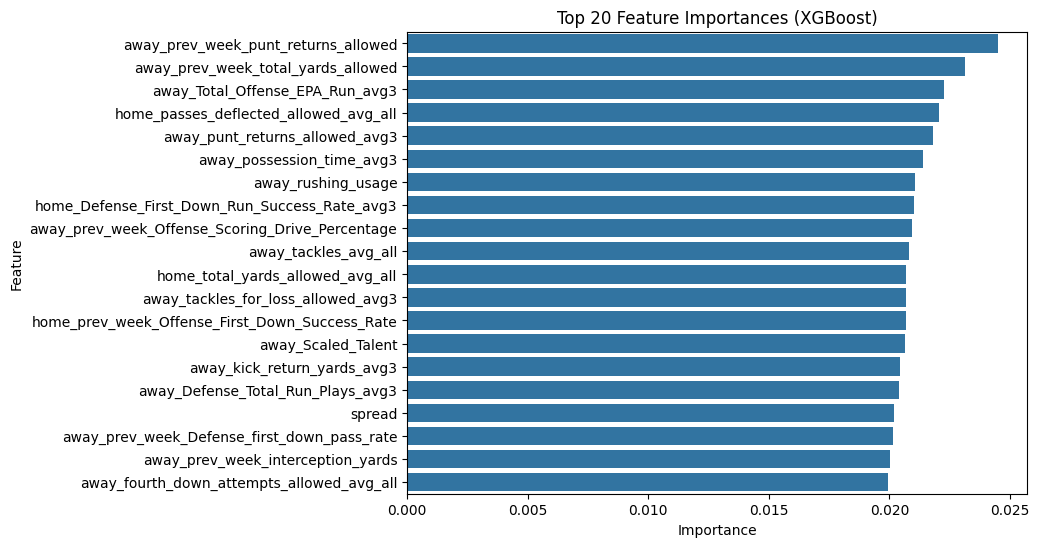

In [60]:
#importance = best_model_imp.feature_importances_
importance = model_imp.feature_importances_
feat_imp = pd.DataFrame({"Feature": X_train_imp.columns, "Importance": importance})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

# Show top 20
plt.figure(figsize=(8,6))
sns.barplot(y="Feature", x="Importance", data=feat_imp.head(20))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

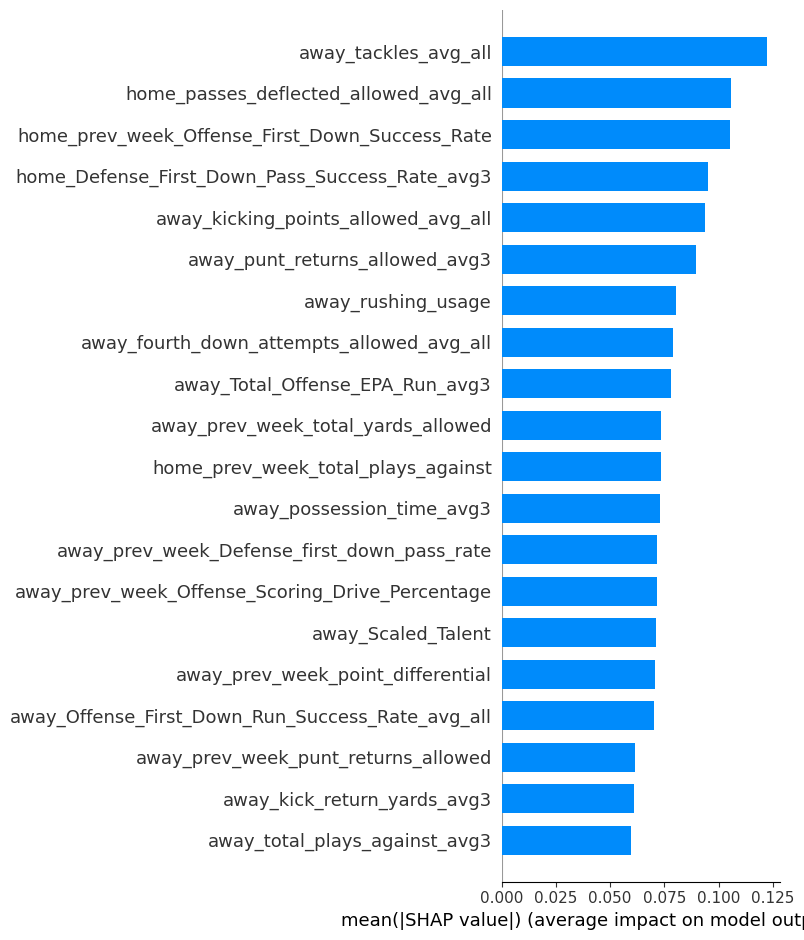

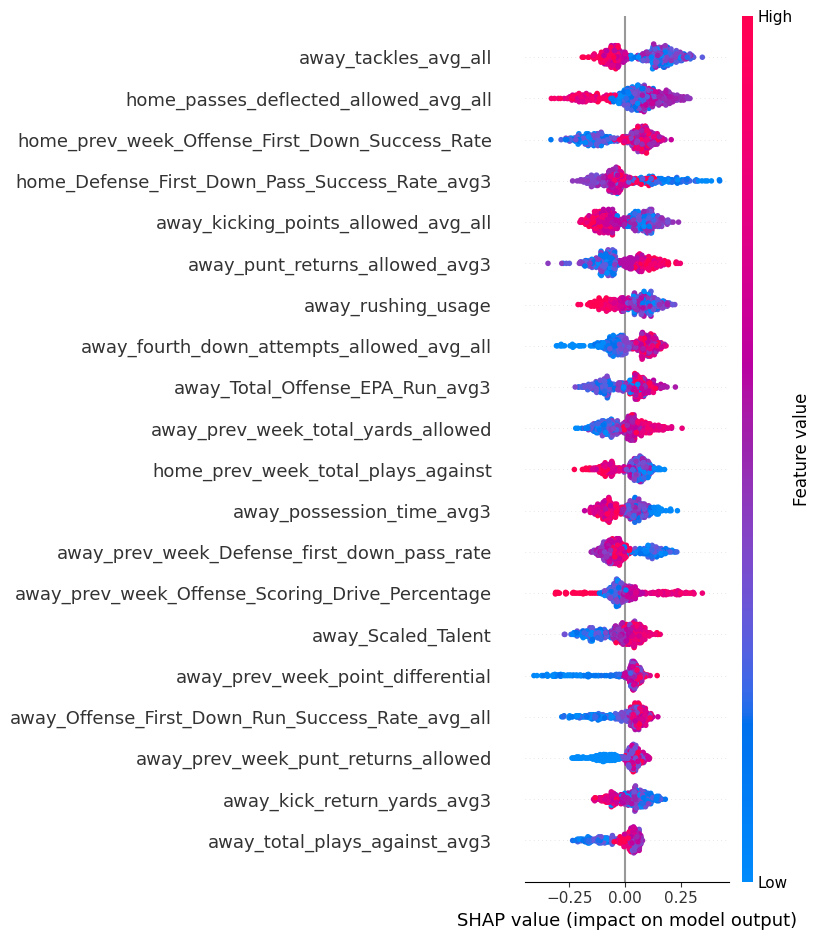

In [61]:
explainer = shap.TreeExplainer(model_imp)
shap_values = explainer.shap_values(X_test_imp)

shap.summary_plot(shap_values, X_test_imp, plot_type="bar")   # global feature importance
shap.summary_plot(shap_values, X_test_imp)   

In [66]:
X_train_imp

home_prev_week_Offense_First_Down_Success_Rate  \
0                                           0.357143   
1                                           0.375000   
2                                           0.400000   
3                                           0.437500   
4                                           0.514286   
...                                              ...   
2166                                        0.629630   
2167                                        0.424242   
2168                                        0.466667   
2169                                        0.472222   
2170                                        0.551724   

      away_possession_time_avg3  away_interception_tds_avg_all  \
0                     30.977778                       0.333333   
1                     37.455556                       0.100000   
2                     32.766667                       0.125000   
3                     29.761111                       0.000000   
4                     33.644444                       0.111111   
...                         ...                            ...   
2166                  30.533333                       0.125000   
2167                  32.483333                       0.111111   
2168                  24.766667                       0.428571   
2169                  30.377778                       0.333333   
2170                  27.772222                       0.000000   

      home_passes_deflected_allowed_avg_all  \
0                                  0.000000   
1                                  0.000000   
2                                  1.000000   
3                                  3.750000   
4                                  5.100000   
...                                     ...   
2166                               4.875000   
2167                               5.888889   
2168                               3.750000   
2169                               2.222222   
2170                               2.200000   

      away_prev_week_punt_returns_allowed  \
0                                       1   
1                                       2   
2                                       2   
3                                       0   
4                                       0   
...                                   ...   
2166                                    2   
2167                                    2   
2168                                    2   
2169                                    2   
2170                                    1   

      away_interception_yards_allowed_avg3  \
0                                11.000000   
1                                 0.000000   
2                                 0.000000   
3                                 6.666667   
4                                 0.000000   
...                                    ...   
2166                              0.000000   
2167                              0.000000   
2168                             25.666667   
2169                              1.333333   
2170                              5.000000   

      away_fourth_down_attempts_allowed_avg_all  \
0                                      0.666667   
1                                      1.400000   
2                                      1.500000   
3                                      1.285714   
4                                      1.555556   
...                                         ...   
2166                                   2.125000   
2167                                   1.888889   
2168                                   2.000000   
2169                                   1.777778   
2170                                   1.333333   

      away_total_plays_against_avg3  \
0                         59.000000   
1                         56.333333   
2                         64.666667   
3                         67.000000   
4                         62.333333   
...                             ..

In [65]:
# Choose your betting threshold
threshold = 0.60

# Align predictions to metadata
test_idx = y_test.index
pred_df = pd.DataFrame({
    "season": data.loc[test_idx, "season"].values,
    "week": data.loc[test_idx, "week"].values,
    "prob": probs_test
})
pred_df["bet"] = (pred_df["prob"] >= threshold).astype(int)

# Bets per week
bets_per_week = (pred_df
                 .groupby(["season", "week"])["bet"]
                 .agg(num_bets="sum", games="count")
                 .reset_index()
                 .sort_values(["season", "week"]))

print(f"Threshold = {threshold}")
print(bets_per_week.head(20))  # preview first weeks

# Overall summary
total_bets = pred_df["bet"].sum()
n_weeks = bets_per_week.shape[0]
avg_per_week = total_bets / n_weeks if n_weeks else 0
median_per_week = bets_per_week["num_bets"].median() if n_weeks else 0
min_per_week = bets_per_week["num_bets"].min() if n_weeks else 0
max_per_week = bets_per_week["num_bets"].max() if n_weeks else 0

print("\nOverall summary:")
print(f"Total bets: {total_bets} across {n_weeks} weeks")
print(f"Avg bets/week: {avg_per_week:.2f}  |  Median: {median_per_week}  |  Min: {min_per_week}  |  Max: {max_per_week}")

# Per-season summary
per_season = (bets_per_week
              .groupby("season")["num_bets"]
              .agg(weeks="count", total_bets="sum", avg_per_week="mean", median_per_week="median")
              .reset_index())
print("\nPer-season summary:")
print(per_season)


Threshold = 0.6
    season  week  num_bets  games
0     2023     4         5     26
1     2023     5         7     28
2     2023     6         5     23
3     2023     7         5     31
4     2023     8         9     23
5     2023     9         6     26
6     2023    10         8     30
7     2023    11         6     35
8     2023    12         9     35
9     2024     4         5     20
10    2024     5         2     20
11    2024     6         4     26
12    2024     7         6     29
13    2024     8        11     32
14    2024     9         8     29
15    2024    10         9     23
16    2024    11        11     29
17    2024    12         7     27

Overall summary:
Total bets: 123 across 18 weeks
Avg bets/week: 6.83  |  Median: 6.5  |  Min: 2  |  Max: 11

Per-season summary:
   season  weeks  total_bets  avg_per_week  median_per_week
0    2023      9          60      6.666667              6.0
1    2024      9          63      7.000000              7.0


In [67]:
import joblib
import json

### Save Final Model
joblib.dump(model_imp, "best_xgb_model_20250915.pkl")

### Save selected features 
with open("selected_features_best_model_20250915.json", "w") as f:
    json.dump(X_train_imp.columns.tolist(), f)

In [47]:
len(important_feats)

103